In [1]:
import matplotlib.pyplot as plt
import numpy as np
from toolbox import scatter_plot

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

# Loading the data set

In [2]:
import pandas as pd

url = "https://covid.ourworldindata.org/data/owid-covid-data.json"
json = pd.read_json(url)

data = json["CHE"]["data"]
df = pd.DataFrame(data)
df.tail()

,date,total_cases,new_cases,total_cases_per_million,new_cases_per_million,stringency_index,new_cases_smoothed,new_deaths_smoothed,new_cases_smoothed_per_million,new_deaths_smoothed_per_million,...,new_tests_smoothed_per_thousand,total_vaccinations,people_vaccinated,total_vaccinations_per_hundred,people_vaccinated_per_hundred,new_vaccinations,new_vaccinations_smoothed,new_vaccinations_smoothed_per_million,people_fully_vaccinated,people_fully_vaccinated_per_hundred
608,2021-10-25,865708.0,3297.0,99329.768,378.292,NaN,1250.143,4.429,143.439,0.508,...,2.695,10995435.0,5698294.0,126.16,65.38,16406.0,19015.0,2182.0,5463926.0,62.69
609,2021-10-26,865708.0,0.0,99329.768,0.000,NaN,1072.857,5.143,123.098,0.590,...,2.725,11012643.0,5703036.0,126.36,65.44,17208.0,18063.0,2073.0,5477094.0,62.84
610,2021-10-27,869044.0,3336.0,99712.535,382.767,NaN,1342.571,4.857,154.044,0.557,...,2.638,11032188.0,5708655.0,126.58,65.50,19545.0,17032.0,1954.0,5491732.0,63.01
611,2021-10-28,870837.0,1793.0,99918.261,205.726,NaN,1387.714,5.857,159.224,0.672,...,NaN,11048010.0,5713304.0,126.76,65.55,15822.0,15961.0,1831.0,5503665.0,63.15
612,2021-10-29,872558.0,1721.0,100115.725,197.464,NaN,1449.571,7.286,166.321,0.836,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [78]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit

df_used = df[['date', 'new_deaths', 'new_cases', 'stringency_index', 'new_tests', 'icu_patients', 'reproduction_rate']]
df_used = df_used.dropna()

X = df_used.index.values.reshape(-1, 1)
X_linear = df_used.index.values.reshape(-1, 1)
X_pred = np.array(len(df)).reshape(-1, 1) # tomorrow
y = df_used['new_deaths'].values.ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
X_train_linear, X_test_linear, y_train_linear, y_test_linear = train_test_split(X_linear, y, random_state=0)
cv = ShuffleSplit(test_size=0.2, train_size=0.8)

# Testing machine learning models

## Linear Models


### Ordinary Least Squares

Best parameters: {}
Training set score: 0.02
Test set score: 0.02
Best cross-validation accuracy: 0.00


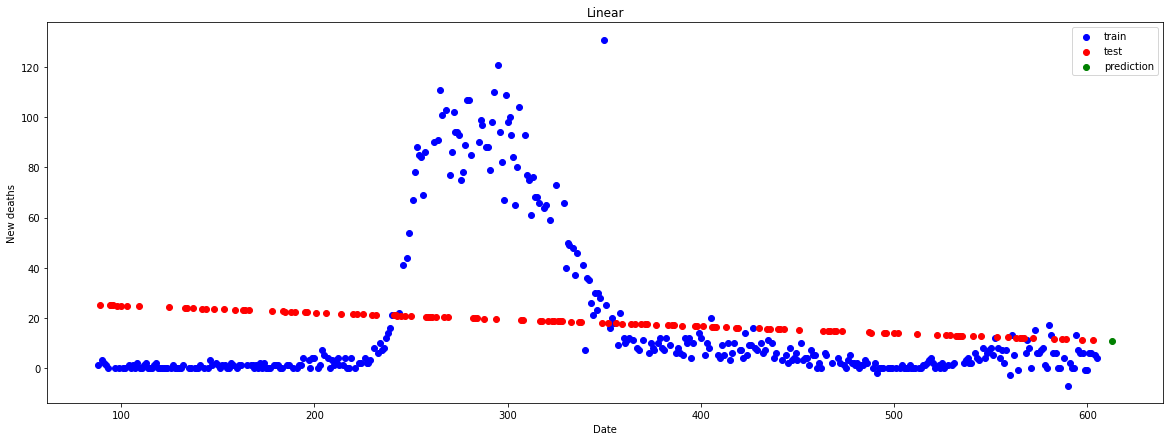

In [79]:
from sklearn.linear_model import LinearRegression

pipeline = Pipeline([("scaler", MinMaxScaler()), ("linear", LinearRegression())]).fit(X_train_linear, y_train_linear)

param_grid = {}

grid = GridSearchCV(pipeline, param_grid=param_grid, cv=cv, n_jobs=-1) # njobs for the number of CPU cores used
grid.fit(X_train_linear, y_train_linear)

print(f"Best parameters: {grid.best_params_}")
print(f"Training set score: {grid.score(X_train_linear, y_train_linear):.2f}")
print(f"Test set score: {grid.score(X_test_linear, y_test_linear):.2f}")
print(f"Best cross-validation accuracy: {grid.best_score_:.2f}")
scatter_plot(X_train_linear, X_test_linear, X_pred, y_train_linear, grid.predict(X_test_linear), grid.predict(X_pred), "Linear")

### Ridge regression

Best parameters: {'ridge__alpha': 1}
Training set score: 0.02
Test set score: 0.02
Best cross-validation accuracy: -0.01


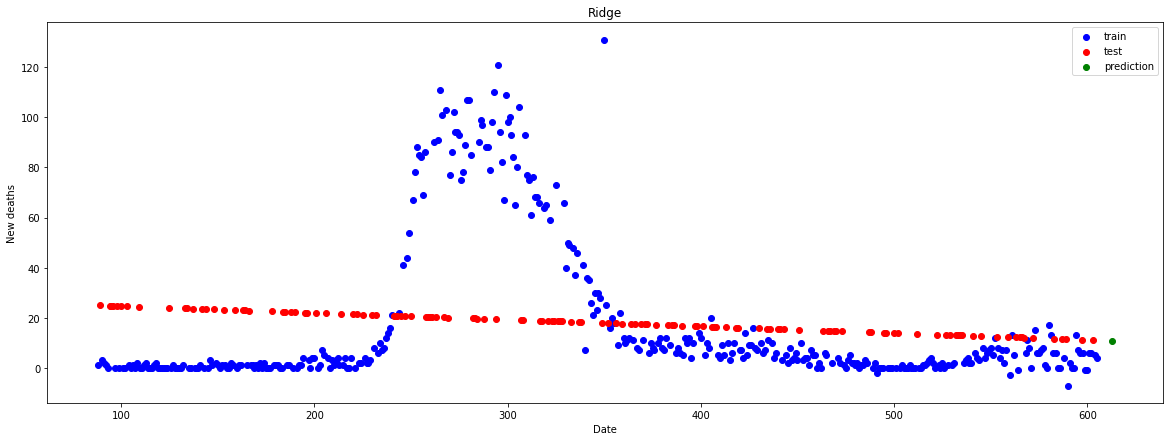

In [80]:
from sklearn.linear_model import Ridge

pipeline = Pipeline([("scaler", MinMaxScaler()), ("ridge", Ridge())]).fit(X_train_linear, y_train_linear)

param_grid = {'ridge__alpha': [0, 0.001, 0.01, 0.1, 1, 10, 100]}

grid = GridSearchCV(pipeline, param_grid=param_grid, cv=cv, n_jobs=-1) 
grid.fit(X_train_linear, y_train_linear)

print(f"Best parameters: {grid.best_params_}")
print(f"Training set score: {grid.score(X_train_linear, y_train_linear):.2f}")
print(f"Test set score: {grid.score(X_test_linear, y_test_linear):.2f}")
print(f"Best cross-validation accuracy: {grid.best_score_:.2f}")
scatter_plot(X_train_linear, X_test_linear, X_pred, y_train_linear, grid.predict(X_test_linear), grid.predict(X_pred), "Ridge")

### Lasso

Best parameters: {'lasso__alpha': 0.1}
Training set score: 0.02
Test set score: 0.02
Best cross-validation accuracy: -0.00


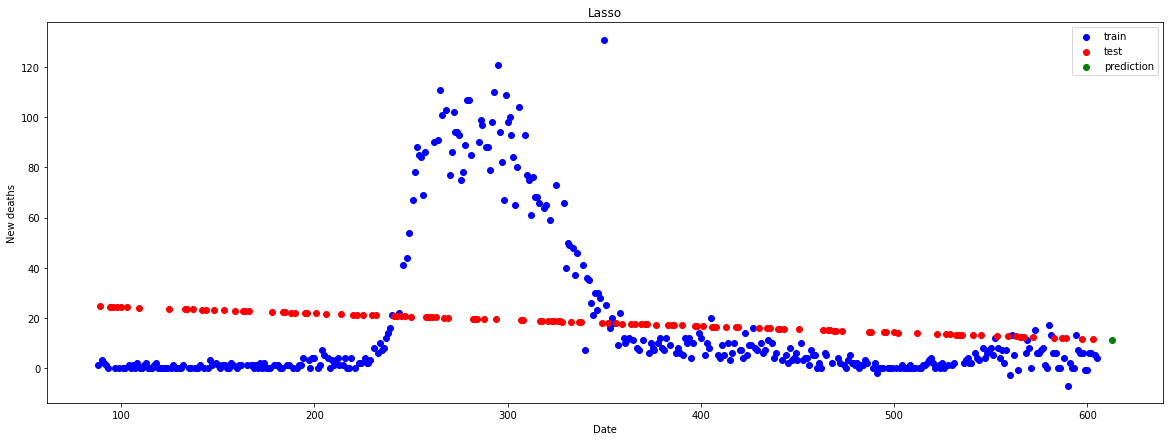

In [81]:
from sklearn.linear_model import Lasso

pipeline = Pipeline([("scaler", MinMaxScaler()), ("lasso", Lasso())]).fit(X_train_linear, y_train_linear)

param_grid = {'lasso__alpha': [0, 0.001, 0.01, 0.1, 1, 10, 100]}

grid = GridSearchCV(pipeline, param_grid=param_grid, cv=cv, n_jobs=-1) # njobs for the number of CPU cores used
grid.fit(X_train_linear, y_train_linear)

print(f"Best parameters: {grid.best_params_}")
print(f"Training set score: {grid.score(X_train_linear, y_train_linear):.2f}")
print(f"Test set score: {grid.score(X_test_linear, y_test_linear):.2f}")
print(f"Best cross-validation accuracy: {grid.best_score_:.2f}")
scatter_plot(X_train_linear, X_test_linear, X_pred, y_train_linear, grid.predict(X_test_linear), grid.predict(X_pred), "Lasso")

### Logistic Regression

Best parameters: {'logistic__C': 1}
Training set score: 0.21
Test set score: 0.17
Best cross-validation accuracy: 0.21


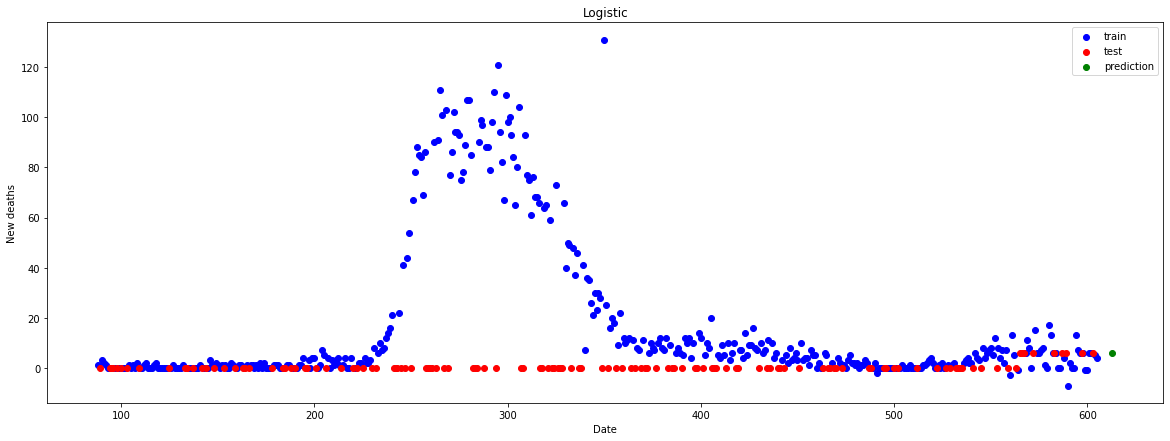

In [84]:
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline([("scaler", MinMaxScaler()), ("logistic", LogisticRegression())]).fit(X_train_linear, y_train_linear)

param_grid = {'logistic__C': [0.001, 0.01, 0.1, 1, 10, 100]}

grid = GridSearchCV(pipeline, param_grid=param_grid, cv=cv, n_jobs=-1) 
grid.fit(X_train_linear, y_train_linear)

print(f"Best parameters: {grid.best_params_}")
print(f"Training set score: {grid.score(X_train_linear, y_train_linear):.2f}")
print(f"Test set score: {grid.score(X_test_linear, y_test_linear):.2f}")
print(f"Best cross-validation accuracy: {grid.best_score_:.2f}")
scatter_plot(X_train_linear, X_test_linear, X_pred, y_train_linear, grid.predict(X_test_linear), grid.predict(X_pred), "Logistic")

## Naive Bayes Classifiers

### Gaussian

Best parameters: {}
Training set score: 0.32
Test set score: 0.14
Best cross-validation accuracy: 0.18


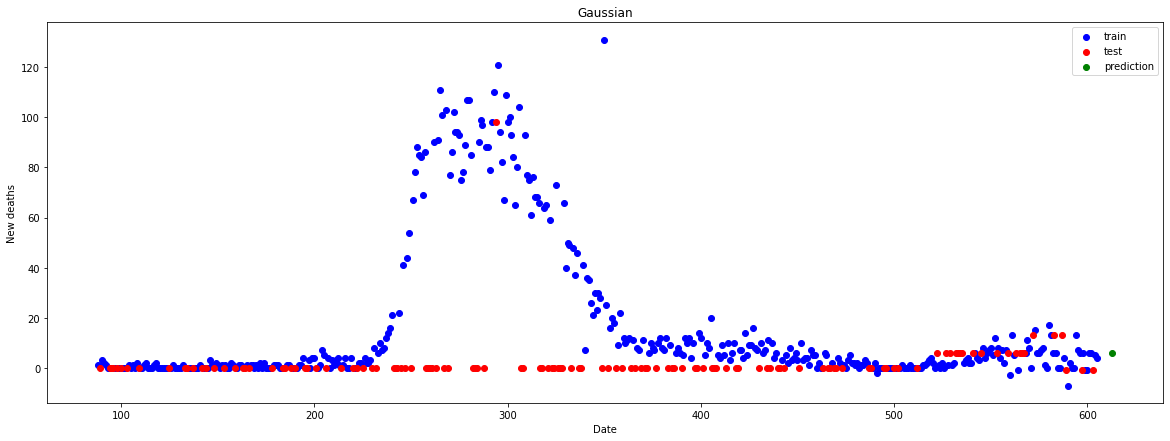

In [85]:
from sklearn.naive_bayes import GaussianNB

pipeline = Pipeline([("scaler", MinMaxScaler()), ("gaussian", GaussianNB())]).fit(X_train, y_train)

param_grid = {}

grid = GridSearchCV(pipeline, param_grid=param_grid, cv=cv, n_jobs=-1) 
grid.fit(X_train, y_train)

print(f"Best parameters: {grid.best_params_}")
print(f"Training set score: {grid.score(X_train, y_train):.2f}")
print(f"Test set score: {grid.score(X_test, y_test):.2f}")
print(f"Best cross-validation accuracy: {grid.best_score_:.2f}")
scatter_plot(X_train[:, 0], X_test[:, 0], X_pred, y_train, grid.predict(X_test), grid.predict(X_pred), "Gaussian")

### Multinomial

Best parameters: {'multinomial__alpha': 0.001}
Training set score: 0.21
Test set score: 0.16
Best cross-validation accuracy: 0.20


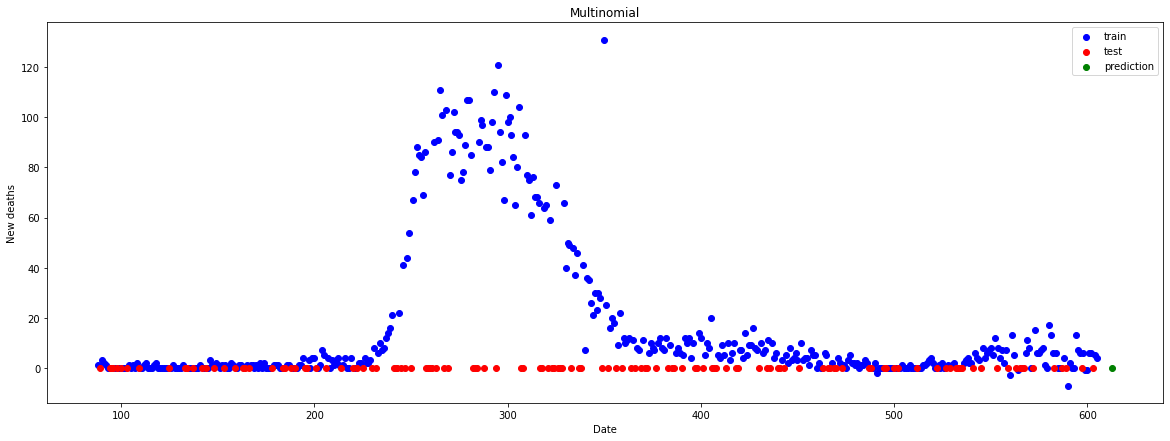

In [86]:
from sklearn.naive_bayes import MultinomialNB

pipeline = Pipeline([("scaler", MinMaxScaler()), ("multinomial", MultinomialNB())]).fit(X_train, y_train)

param_grid = {'multinomial__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

grid = GridSearchCV(pipeline, param_grid=param_grid, cv=cv, n_jobs=-1) 
grid.fit(X_train, y_train)

print(f"Best parameters: {grid.best_params_}")
print(f"Training set score: {grid.score(X_train, y_train):.2f}")
print(f"Test set score: {grid.score(X_test, y_test):.2f}")
print(f"Best cross-validation accuracy: {grid.best_score_:.2f}")
scatter_plot(X_train[:, 0], X_test[:, 0], X_pred, y_train, grid.predict(X_test), grid.predict(X_pred), "Multinomial")

## K-Nearest Neighbors

Best parameters: {'knn__n_neighbors': 9}
Training set score: 0.94
Test set score: 0.84
Best cross-validation accuracy: 0.92


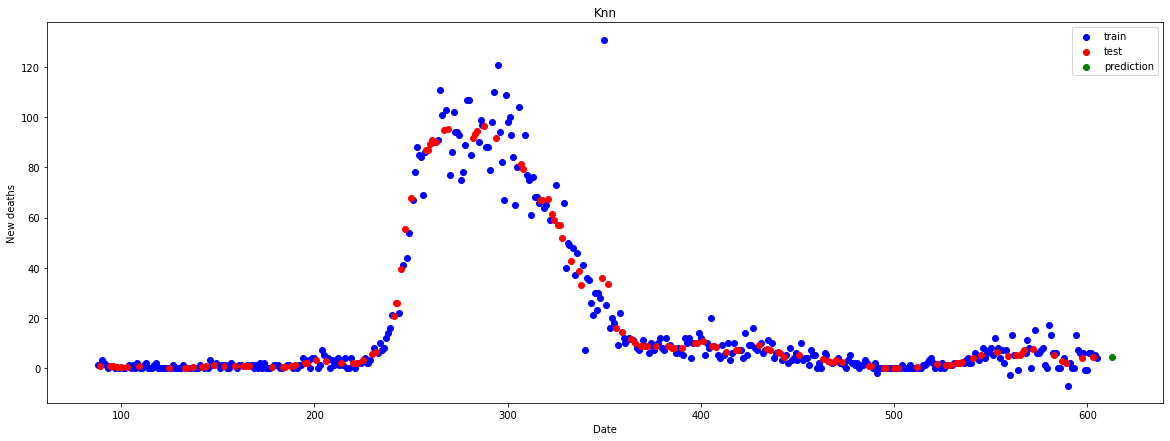

In [87]:
from sklearn.neighbors import KNeighborsRegressor

pipeline = Pipeline([("scaler", MinMaxScaler()), ("knn", KNeighborsRegressor())]).fit(X_train, y_train)

param_grid = {'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40]}

grid = GridSearchCV(pipeline, param_grid=param_grid, cv=cv, n_jobs=-1) 
grid.fit(X_train, y_train)

print(f"Best parameters: {grid.best_params_}")
print(f"Training set score: {grid.score(X_train, y_train):.2f}")
print(f"Test set score: {grid.score(X_test, y_test):.2f}")
print(f"Best cross-validation accuracy: {grid.best_score_:.2f}")
scatter_plot(X_train[:, 0], X_test[:, 0], X_pred, y_train, grid.predict(X_test), grid.predict(X_pred), "Knn")

## Decision Trees


### Simple Decision Trees

C:\Users\leon.muller\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan 0.13113786 0.79025107 0.88018269
 0.86136263 0.86782549 0.86980748 0.86286184 0.85947372 0.86025019
 0.85849601 0.8547642 ]
  warnings.warn(


Best parameters: {'tree__criterion': 'friedman_mse', 'tree__max_depth': 3}
Training set score: 0.91
Test set score: 0.76
Best cross-validation accuracy: 0.88


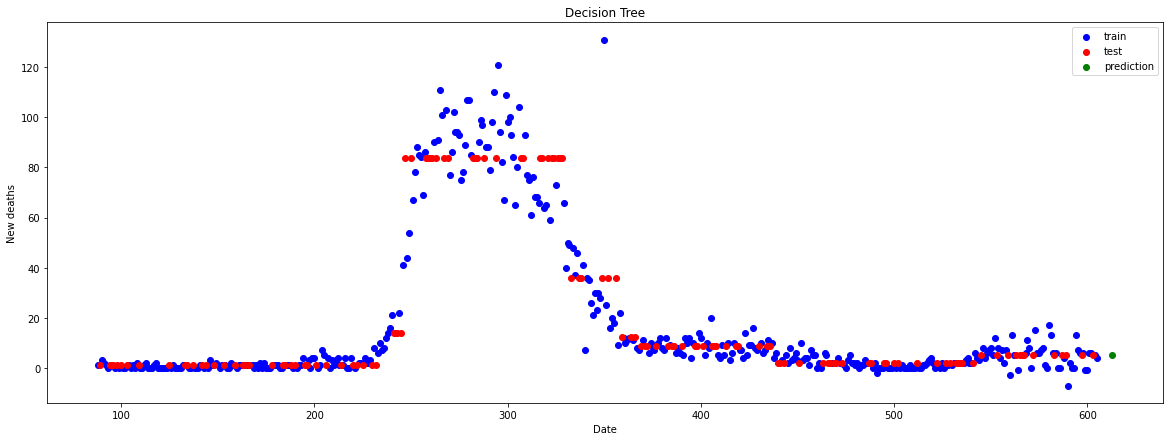

In [88]:
from sklearn.tree import DecisionTreeRegressor

pipeline = Pipeline([("scaler", MinMaxScaler()), ("tree", DecisionTreeRegressor())]).fit(X_train, y_train)

param_grid = {'tree__criterion': ["squared_error", "absolute_error", "poisson", "friedman_mse"], 'tree__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, None]}

grid = GridSearchCV(pipeline, param_grid=param_grid, cv=cv, n_jobs=-1) 
grid.fit(X_train, y_train)

print(f"Best parameters: {grid.best_params_}")
print(f"Training set score: {grid.score(X_train, y_train):.2f}")
print(f"Test set score: {grid.score(X_test, y_test):.2f}")
print(f"Best cross-validation accuracy: {grid.best_score_:.2f}")
scatter_plot(X_train[:, 0], X_test[:, 0], X_pred, y_train, grid.predict(X_test), grid.predict(X_pred), "Decision Tree")

### Random Forest

C:\Users\leon.muller\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        n

Best parameters: {'forest__criterion': 'poisson', 'forest__max_depth': None, 'forest__n_estimators': 10}
Training set score: 0.99
Test set score: 0.74
Best cross-validation accuracy: 0.92


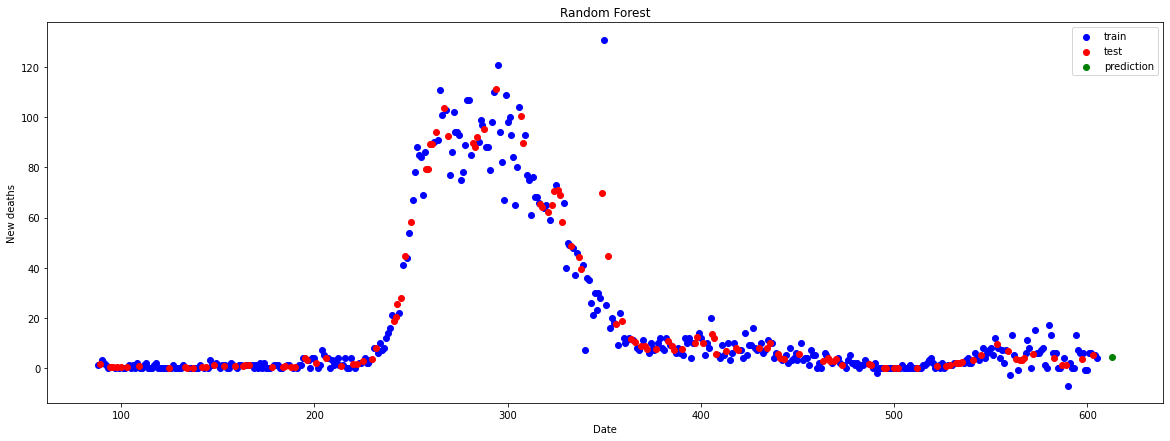

In [89]:
from sklearn.ensemble import RandomForestRegressor

pipeline = Pipeline([("scaler", MinMaxScaler()), ("forest", RandomForestRegressor())]).fit(X_train, y_train)

param_grid = {'forest__criterion': ["squared_error", "absolute_error", "poisson"], 'forest__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, None], 'forest__n_estimators': [1, 5, 10, 50, 100, 500, 1000]}

grid = GridSearchCV(pipeline, param_grid=param_grid, cv=cv, n_jobs=-1) # njobs for the number of CPU cores used
grid.fit(X_train, y_train)

print(f"Best parameters: {grid.best_params_}")
print(f"Training set score: {grid.score(X_train, y_train):.2f}")
print(f"Test set score: {grid.score(X_test, y_test):.2f}")
print(f"Best cross-validation accuracy: {grid.best_score_:.2f}")
scatter_plot(X_train[:, 0], X_test[:, 0], X_pred, y_train, grid.predict(X_test), grid.predict(X_pred), "Random Forest")

### Gradient Boosted Trees

C:\Users\leon.muller\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [             nan              nan              nan              nan
              nan              nan              nan              nan
              nan              nan              nan              nan
              nan              nan              nan              nan
              nan              nan              nan              nan
              nan              nan              nan              nan
              nan              nan              nan              nan
              nan              nan              nan              nan
              nan              nan              nan              nan
              nan              nan              nan              nan
              nan              nan              nan              na

Best parameters: {'gradient_boosting__criterion': 'friedman_mse', 'gradient_boosting__learning_rate': 0.01, 'gradient_boosting__loss': 'huber', 'gradient_boosting__n_estimators': 1000}
Training set score: 0.96
Test set score: 0.85
Best cross-validation accuracy: 0.94


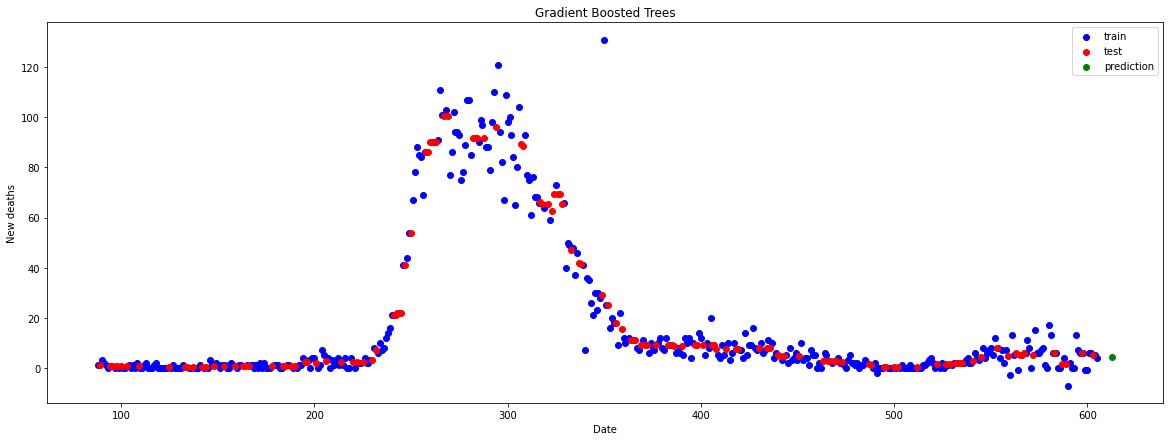

In [90]:
from sklearn.ensemble import GradientBoostingRegressor

pipeline = Pipeline([("scaler", MinMaxScaler()), ("gradient_boosting", GradientBoostingRegressor())]).fit(X_train, y_train)

param_grid = {'gradient_boosting__criterion': ["squared_error", "friedman_mse"], 'gradient_boosting__loss': ["squared_error", "absolute_error", "huber", "quantile"], 'gradient_boosting__n_estimators': [1, 5, 10, 50, 100, 500, 1000], 'gradient_boosting__learning_rate': [0, 0.001, 0.01, 0.1, 1, 10, 100]}

grid = GridSearchCV(pipeline, param_grid=param_grid, cv=cv, n_jobs=-1) # njobs for the number of CPU cores used
grid.fit(X_train, y_train)

print(f"Best parameters: {grid.best_params_}")
print(f"Training set score: {grid.score(X_train, y_train):.2f}")
print(f"Test set score: {grid.score(X_test, y_test):.2f}")
print(f"Best cross-validation accuracy: {grid.best_score_:.2f}")
scatter_plot(X_train[:, 0], X_test[:, 0], X_pred, y_train, grid.predict(X_test), grid.predict(X_pred), "Gradient Boosted Trees")

## Support Vector Regression

Best parameters: {'svr__C': 100, 'svr__gamma': 100}
Training set score: 0.93
Test set score: 0.84
Best cross-validation accuracy: 0.91


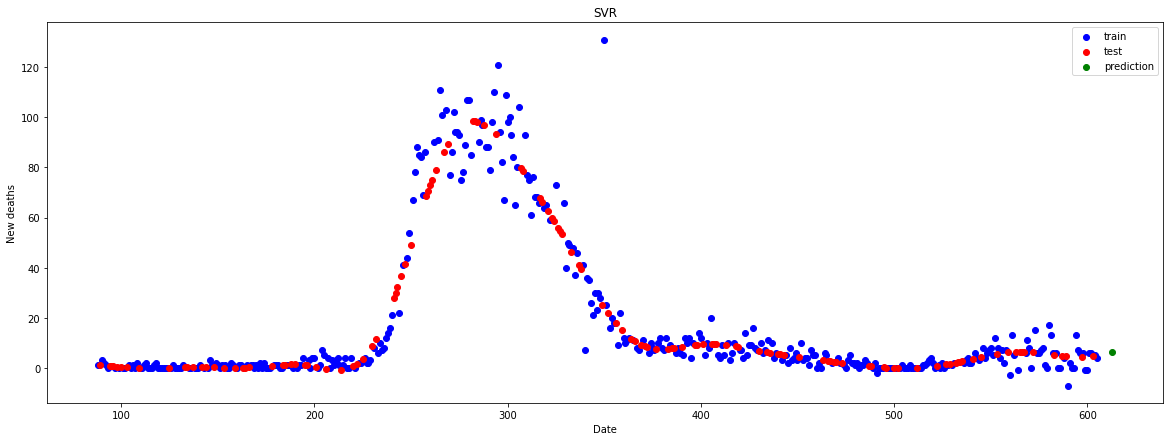

In [91]:
from sklearn.svm import SVR

pipeline = Pipeline([("scaler", MinMaxScaler()), ("svr", SVR())]).fit(X_train, y_train)

param_grid = {'svr__C': [0.001, 0.01, 0.1, 1, 10, 100], 'svr__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

grid = GridSearchCV(pipeline, param_grid=param_grid, cv=cv, n_jobs=-1) # njobs for the number of CPU cores used
grid.fit(X_train, y_train)

print(f"Best parameters: {grid.best_params_}")
print(f"Training set score: {grid.score(X_train, y_train):.2f}")
print(f"Test set score: {grid.score(X_test, y_test):.2f}")
print(f"Best cross-validation accuracy: {grid.best_score_:.2f}")
scatter_plot(X_train[:, 0], X_test[:, 0], X_pred, y_train, grid.predict(X_test), grid.predict(X_pred), "SVR")

## Multi-Layer Perceptrons (Deep Learning)

In [94]:
from sklearn.neural_network import MLPRegressor

pipeline = Pipeline([("scaler", MinMaxScaler()), ("mlp", MLPRegressor())]).fit(X_train, y_train)

param_grid = {'mlp__hidden_layer_sizes': [1, 10, 100, 1000], 'mlp__alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100], 'mlp__activation': ['identity', 'logistic', 'tanh', 'relu'], 'mlp__solver': ['lbfgs', 'sgd', 'adam'], 'mlp__max_iter': [1000]}

grid = GridSearchCV(pipeline, param_grid=param_grid, cv=cv, n_jobs=-1) # njobs for the number of CPU cores used
grid.fit(X_train, y_train)

print(f"Best parameters: {grid.best_params_}")
print(f"Training set score: {grid.score(X_train, y_train):.2f}")
print(f"Test set score: {grid.score(X_test, y_test):.2f}")
print(f"Best cross-validation accuracy: {grid.best_score_:.2f}")
scatter_plot(X_train[:, 0], X_test[:, 0], X_pred, y_train, grid.predict(X_test), grid.predict(X_pred), "MLP")

C:\Users\leon.muller\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
